In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from hidmed import *
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

In [3]:
n = 4000
xdim = 1
zdim = 1
wdim = 1
mdim = 1
udim = 1
datagen = LinearHidMedDataset(xdim, zdim, wdim, mdim, udim, setup="a")


def sweep_hyperparameters(
    n,
    setup,
    nonnegative=True,
    azwy_nonnegative=False,
    seed=0,
    n_xfit=5,
    n_max=10000,
    maxfev=100,
    gamma_h=None,
    gamma_q=None,
):
    datagen = LinearHidMedDataset(
        xdim,
        zdim,
        wdim,
        mdim,
        udim,
        setup=setup,
        nonnegative=nonnegative,
        azwy_nonnegative=azwy_nonnegative,
        seed=seed,
    )
    data = datagen.sample_dataset(n_max, seed=0)
    if n_xfit == -1:
        data = HidMedDataset(
            data.get_X(np.arange(2 * n)),
            data.get_U(np.arange(2 * n)),
            data.get_A(np.arange(2 * n)),
            data.get_M(np.arange(2 * n)),
            data.get_W(np.arange(2 * n)),
            data.get_Z(np.arange(2 * n)),
            data.get_Y(np.arange(2 * n)),
        )

        est = ProximalHidMedRKHS(
            data,
            create_kernel(n_jobs=5, gamma=gamma_h),
            create_kernel(n_jobs=5, gamma=gamma_q),
        )
        lambdas_h = est.optimize_lambdas("h", 1, 2, maxfev=maxfev, grid_search=True)
        lambdas_q = est.optimize_lambdas("q", 1, 2, maxfev=maxfev, grid_search=True)
    else:
        data = HidMedDataset(
            data.get_X(np.arange(n)),
            data.get_U(np.arange(n)),
            data.get_A(np.arange(n)),
            data.get_M(np.arange(n)),
            data.get_W(np.arange(n)),
            data.get_Z(np.arange(n)),
            data.get_Y(np.arange(n)),
        )
        est = ProximalHidMedRKHS(
            data,
            create_kernel(n_jobs=5, gamma=gamma_h),
            create_kernel(n_jobs=5, gamma=gamma_q),
        )
        lambdas_h = est.optimize_lambdas(
            "h", 1, n_xfit, maxfev=maxfev, grid_search=True
        )
        lambdas_q = est.optimize_lambdas(
            "q", 1, n_xfit, maxfev=maxfev, grid_search=True
        )
    return lambdas_h, lambdas_q


def run(
    n,
    runs,
    setup,
    lambdas_h,
    lambdas_q,
    alpha,
    gamma_dr,
    nonnegative=True,
    azwy_nonnegative=False,
    seed=0,
    n_xfit=5,
    n_max=10000,
    gamma_h=None,
    gamma_q=None,
):
    datagen = LinearHidMedDataset(
        xdim,
        zdim,
        wdim,
        mdim,
        udim,
        setup=setup,
        nonnegative=nonnegative,
        azwy_nonnegative=azwy_nonnegative,
        seed=seed,
    )

    # ground truth
    true_psi = datagen.true_psi(n=100000)

    coverage_h = 0.0
    coverage_q = 0.0
    coverage_d = 0.0

    ci_h = 0.0
    ci_q = 0.0
    ci_d = 0.0

    bias_h = 0.0
    bias_q = 0.0
    bias_d = 0.0

    var_h = 0.0
    var_q = 0.0
    var_d = 0.0

    mse_h = 0.0
    mse_q = 0.0
    mse_d = 0.0

    psi_est_h = []
    psi_est_q = []
    psi_est_d = []
    for i in tqdm(range(runs)):
        data = datagen.sample_dataset(n_max, seed=seed + i + 1)

        if lambdas_h is None or lambdas_q is None:
            data_tuning = HidMedDataset(
                data.get_X(np.arange(2 * n)),
                data.get_U(np.arange(2 * n)),
                data.get_A(np.arange(2 * n)),
                data.get_M(np.arange(2 * n)),
                data.get_W(np.arange(2 * n)),
                data.get_Z(np.arange(2 * n)),
                data.get_Y(np.arange(2 * n)),
            )
            est_tuning = ProximalHidMedRKHS(
                data_tuning,
                create_kernel(n_jobs=5, gamma=gamma_h),
                create_kernel(n_jobs=5, gamma=gamma_q),
            )
            lambdas_h = est_tuning.optimize_lambdas(
                "h", 1, 2, maxfev=25, grid_search=True
            )
            lambdas_q = est_tuning.optimize_lambdas(
                "q", 1, 2, maxfev=25, grid_search=True
            )

        data = HidMedDataset(
            data.get_X(np.arange(n)),
            data.get_U(np.arange(n)),
            data.get_A(np.arange(n)),
            data.get_M(np.arange(n)),
            data.get_W(np.arange(n)),
            data.get_Z(np.arange(n)),
            data.get_Y(np.arange(n)),
        )
        est = ProximalHidMedRKHS(
            data,
            create_kernel(n_jobs=5, gamma=gamma_h),
            create_kernel(n_jobs=5, gamma=gamma_q),
        )

        psi1_h = est.plugin_h(
            lambdas_h,
            1.0,
            None,
            n_xfit,
            psis=1 if datagen.setup == "a" else 2,
            get_raw=True,
        )
        # psi1_q = est.plugin_q_prop(lambdas_q, alpha, n_xfit, psis = 1 if datagen.setup == "a" else 2, get_raw=True)
        psi1_q = est.plugin_q(
            lambdas_q,
            alpha,
            gamma_q,
            n_xfit,
            psis=1 if datagen.setup == "a" else 2,
            get_raw=True,
        )
        psi1_d = est.double_robust(
            lambdas_h,
            lambdas_q,
            alpha,
            gamma_dr,
            n_xfit,
            psis=1 if datagen.setup == "a" else 2,
            get_raw=True,
        )

        psi_est_h.append(np.mean(psi1_h))
        psi_est_q.append(np.mean(psi1_q))
        psi_est_d.append(np.mean(psi1_d))

        coverage_h += is_covered(psi1_h, true_psi) / runs
        coverage_q += is_covered(psi1_q, true_psi) / runs
        coverage_d += is_covered(psi1_d, true_psi) / runs

        bias_h += (np.mean(psi1_h) - true_psi) / runs
        bias_q += (np.mean(psi1_q) - true_psi) / runs
        bias_d += (np.mean(psi1_d) - true_psi) / runs

        var_h += np.var(psi1_h) / runs
        var_q += np.var(psi1_q) / runs
        var_d += np.var(psi1_d) / runs

        mse_h += calculate_mse(psi1_h, true_psi) / runs
        mse_q += calculate_mse(psi1_q, true_psi) / runs
        mse_d += calculate_mse(psi1_d, true_psi) / runs

        ci_h += 2 * (1.96 * np.std(psi1_h) / np.sqrt(len(psi1_h))) / runs
        ci_q += 2 * (1.96 * np.std(psi1_q) / np.sqrt(len(psi1_q))) / runs
        ci_d += 2 * (1.96 * np.std(psi1_d) / np.sqrt(len(psi1_d))) / runs

    return {
        "psi_est_h": psi_est_h,
        "psi_est_q": psi_est_q,
        "psi_est_d": psi_est_d,
        "true": true_psi,
        "coverage_h": coverage_h,
        "coverage_q": coverage_q,
        "coverage_d": coverage_d,
        "mse_h": mse_h,
        "mse_q": mse_q,
        "mse_d": mse_d,
        "bias_h": bias_h,
        "bias_q": bias_q,
        "bias_d": bias_d,
        "var_h": var_h,
        "var_q": var_q,
        "var_d": var_d,
        "ci_h": ci_h,
        "ci_q": ci_q,
        "ci_d": ci_d,
    }

# sweep sample sizes

In [4]:
seed = 2

# cross fitting folds
n_xfit = 2

# number of trials
num_runs = 10

# sweep sample sizes
sample_sizes = [2000, 3000, 4000]
if n_xfit > 0:
    sample_sizes = [int(s * n_xfit / (n_xfit - 1)) for s in sample_sizes]

# set some hyperparameters
gammas = {
    "a": np.array([1e-3, 1e-3, 1e-3]) * 5,
    "b": np.array([1e-3, 1e-3, 1e-3]) * 0.5,
    "c": np.array([1e-3, 1e-3, 1e-3]) * 0.5,
}
alphas = {
    "a": [200, 200, 200],
    "b": [5000, 5000, 5000],
    "c": [5000, 5000, 5000],
}
gamma_drs = {
    "a": [5, 5, 5],
    "b": [100 * 1e-3, 100 * 1e-3, 100 * 1e-3],
    "c": [1e-3 * 100, 1e-3 * 100, 1e-3 * 100],
}

results = {}
for setup in ["a", "b", "c"]:
    # choose minimax hyperparameters by validation
    n_fit = sample_sizes[0]
    lambdas_h, lambdas_q = sweep_hyperparameters(
        n_fit,
        setup,
        seed=seed,
        n_xfit=n_xfit,
        maxfev=100,
        gamma_h=gammas[setup][0],
        gamma_q=gammas[setup][0],
    )
    lambdas_h_scale = lambdas_h * n_fit**0.8
    lambdas_q_scale = lambdas_q * n_fit**0.8
    for i in range(len(sample_sizes)):
        n = sample_sizes[i]

        lambdas_h = lambdas_h_scale / n**0.8
        lambdas_q = lambdas_q_scale / n**0.8

        # run estimator
        results[n, setup] = run(
            n,
            num_runs,
            setup,
            lambdas_h,
            lambdas_q,
            alphas[setup][i],
            gamma_drs[setup][i],
            n_xfit=n_xfit,
            gamma_h=gammas[setup][i],
            gamma_q=gammas[setup][i],
            seed=seed,
        )

        # calculate metrics
        abs_norm_bias_h = (
            np.abs(results[n, setup]["bias_h"]) / results[n, setup]["true"]
        )
        abs_norm_bias_q = (
            np.abs(results[n, setup]["bias_q"]) / results[n, setup]["true"]
        )
        abs_norm_bias_d = (
            np.abs(results[n, setup]["bias_d"]) / results[n, setup]["true"]
        )

        print(setup, n)
        print(lambdas_h, lambdas_q, alphas[setup][i], gamma_drs[setup][i])
        print(
            "coverages:",
            results[n, setup]["coverage_h"],
            results[n, setup]["coverage_q"],
            results[n, setup]["coverage_d"],
        )
        print(
            "length:",
            results[n, setup]["ci_h"],
            results[n, setup]["ci_q"],
            results[n, setup]["ci_d"],
        )
        print(
            "MSEs:",
            results[n, setup]["mse_h"],
            results[n, setup]["mse_q"],
            results[n, setup]["mse_d"],
        )
        print("anb: ", abs_norm_bias_h, abs_norm_bias_q, abs_norm_bias_d)
        print("true: ", results[n, setup]["true"])

100%|██████████| 10/10 [00:57<00:00,  5.73s/it]


a 4000
[2.28652526e-08 1.37073588e-07] [2.28652526e-08 2.28652526e-08] 200 5
coverages: 0.6 0.0 0.9999999999999999
length: 0.12636526318457686 0.007617221434644011 0.29074078634745676
MSEs: 0.004684941250606018 0.019361214426050252 0.00851008820568927
anb:  0.020873067623307203 0.04906113261066252 0.0029546211476398684
true:  2.0


100%|██████████| 10/10 [02:21<00:00, 14.19s/it]


a 6000
[1.65311473e-08 9.91016246e-08] [1.65311473e-08 1.65311473e-08] 200 5
coverages: 0.7 0.0 0.9999999999999999
length: 0.10352859356202898 0.0063611961958391135 0.22237764025156997
MSEs: 0.002679405860930032 0.005907558357346841 0.005245158721878492
anb:  0.013502178472587344 0.0016975428973906802 0.003953559523239292
true:  2.0


100%|██████████| 10/10 [04:43<00:00, 28.35s/it]


a 8000
[1.31326390e-08 7.87281026e-08] [1.3132639e-08 1.3132639e-08] 200 5
coverages: 0.6 0.0 0.8999999999999999
length: 0.09043118973529203 0.0065971785974699125 0.18777990908254796
MSEs: 0.002487621108655904 0.006320278794797594 0.004885179951955568
anb:  0.012045543822740834 0.025046025801118806 0.004737081847714197
true:  2.0


100%|██████████| 10/10 [00:57<00:00,  5.80s/it]


b 4000
[2.28652526e-08 2.28652526e-08] [8.21734572e-07 1.37073588e-07] 5000 0.1
coverages: 0.4 0.8999999999999999 0.7
length: 0.0663926219575518 0.2500286427200972 0.16834022300427418
MSEs: 0.005989876665353201 0.011414198208031561 0.007292172296641973
anb:  0.09420278618221345 0.1782133780528247 0.0675785417918175
true:  0.4051673142251253


100%|██████████| 10/10 [02:19<00:00, 13.91s/it]


b 6000
[1.65311473e-08 1.65311473e-08] [5.94098631e-07 9.91016246e-08] 5000 0.1
coverages: 0.6 0.7999999999999999 0.7999999999999999
length: 0.05477324688397931 0.2308893111168784 0.13944050268696306
MSEs: 0.002336153134065594 0.012200088151645859 0.0037344545002834214
anb:  0.03257441263908319 0.22076584019534856 0.0050489788827868766
true:  0.39321816254481695


100%|██████████| 10/10 [04:42<00:00, 28.21s/it]


b 8000
[1.3132639e-08 1.3132639e-08] [4.71962576e-07 7.87281026e-08] 5000 0.1
coverages: 0.7 0.7999999999999999 0.8999999999999999
length: 0.04802870979585856 0.21529235831991422 0.12290642411316194
MSEs: 0.0014263681211397908 0.011057606474082712 0.00254733146445234
anb:  0.01802434530213638 0.21440600504989665 0.005509177623767155
true:  0.39692239933320045


100%|██████████| 10/10 [00:57<00:00,  5.74s/it]


c 4000
[2.28652526e-08 2.28652526e-08] [8.21734572e-07 1.37073588e-07] 5000 0.1
coverages: 0.5 0.6 0.7999999999999999
length: 0.0836010756092501 0.38587165915010246 0.22695437645118732
MSEs: 0.006921140245947864 0.04193155125431068 0.009105245618097028
anb:  0.028571877254266555 0.1191132685810723 0.014671242777561804
true:  1.3987063702398013


100%|██████████| 10/10 [02:19<00:00, 13.93s/it]


c 6000
[1.65311473e-08 1.65311473e-08] [5.94098631e-07 9.91016246e-08] 5000 0.1
coverages: 0.6 0.7999999999999999 0.8999999999999999
length: 0.06889074719361477 0.35747526777670846 0.18291144149205107
MSEs: 0.00291828164498803 0.025012487221430797 0.0050024837111199115
anb:  0.013956118390734441 0.08665627398857001 0.0013833277739005157
true:  1.3957637109986292


100%|██████████| 10/10 [04:49<00:00, 28.92s/it]

c 8000
[1.3132639e-08 1.3132639e-08] [4.71962576e-07 7.87281026e-08] 5000 0.1
coverages: 0.7 0.9999999999999999 0.9999999999999999
length: 0.06043057784094655 0.3333438036553459 0.15788937178149087
MSEs: 0.0016130554662728135 0.01875808587811091 0.00338239694728529
anb:  0.006542056730125004 0.07204866629530582 0.0002509124672781036
true:  1.3985422793591717


In [5]:
import pickle

pickle.dump(results, open("assets/prox_hidmed_1dim_results.pkl", "wb"))

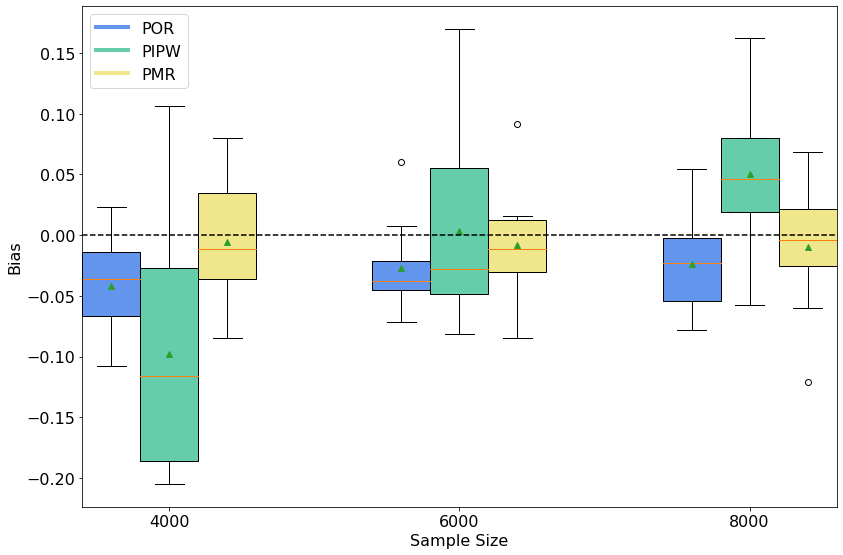

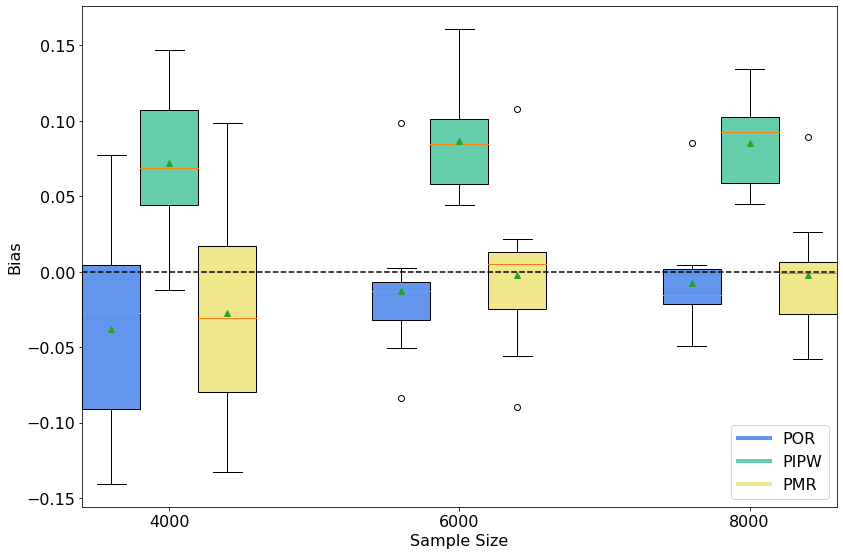

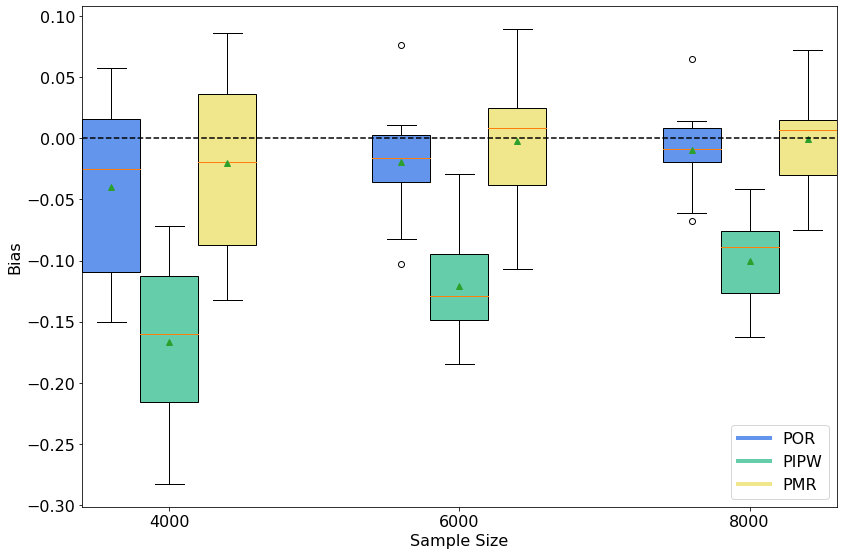

In [6]:
import matplotlib
from matplotlib.lines import Line2D

keys = ["psi_est_h", "psi_est_q", "psi_est_d"]
font = {"size": 16}
matplotlib.rc("font", **font)

for mode in ["a", "b", "c"]:
    idx = 1
    positions = []
    for col in range(len(sample_sizes)):
        for i in range(len(keys)):
            positions.append(idx)
            idx += 1
        idx += 2

    labels = [
        sample_sizes[col] if i == 2 else " "
        for col in range(len(sample_sizes))
        for i in range(3)
    ]

    fig, ax = plt.subplots(figsize=(2 * 3 * 2, 4 * 2))
    plotdata = []
    for n in sample_sizes:
        for key in keys:
            plotdata.append(np.array(results[n, mode][key]) - results[n, mode]["true"])

    bplot = ax.boxplot(
        np.vstack(plotdata).T,
        positions=positions,
        labels=labels,
        patch_artist=True,
        widths=1,
        showmeans=True,
    )
    # bplot = ax.violinplot(np.vstack(plotdata).T, positions = positions, widths=1)

    base_colors = ["cornflowerblue", "mediumaquamarine", "khaki"]
    colors = [c for _ in range(len(sample_sizes)) for c in base_colors]
    for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)

    custom_lines = [Line2D([0], [0], color=c, lw=4) for c in base_colors]
    ax.legend(custom_lines, ["POR", "PIPW", "PMR"])

    ax.axhline(y=0.0, color="k", linestyle="--", zorder=3)
    # plt.ylim(-2.5, 2.5)
    plt.xticks(positions[1 :: len(keys)], sample_sizes)
    plt.xlabel("Sample Size")
    plt.ylabel("Bias")
    plt.tight_layout()
    plt.savefig("assets/prox_hidmed_1d_sample_sizes_setup_%s.png" % mode, dpi=500)
    plt.show()